In [1]:
import datetime

import pandas as pd
from yahoofinancials import YahooFinancials

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# grab tickers we need
long_positions = ['VHT', 'VDC', 'VPU', 'VOX']
short_positions = ['SH']
benchmarks = ['SPY']
short_dir = 1

In [3]:
# get price data
yf = YahooFinancials(long_positions + short_positions + benchmarks)

data = yf.get_historical_price_data(start_date='2000-01-01', 
                                    end_date=datetime.date.today().strftime('%Y-%m-%d'), 
                                    time_interval='daily')

df = []
for k,v in data.items():
    df_t = pd.DataFrame(v['prices'])
    df_t['ticker'] = k
    df.append(df_t)

df = pd.concat(df, axis=0, ignore_index=True, sort=False)
df['formatted_date'] = pd.to_datetime(df.formatted_date)
df['week'] = df.formatted_date.apply(lambda x: x - datetime.timedelta(days=x.weekday()))

In [4]:
# filter to period with pricing for all tickers
first_dt = df.groupby(['ticker'])['formatted_date'].min().max()
last_dt = df.groupby(['ticker'])['formatted_date'].max().min()
df2 = df.loc[(df.formatted_date >= first_dt) & (df.formatted_date <= last_dt), :].copy()
assert df2.groupby(['ticker']).agg({'formatted_date': 'count'}).nunique()[0] == 1

In [5]:
# aggregate to weekly
df2.sort_values(by=['ticker', 'formatted_date'], ascending=True, inplace=True)
df3 = df2.groupby(['ticker', 'week'], as_index=False).tail(1)[['ticker', 'week', 'adjclose']].copy()
df3['adjclose_lag1'] = df3.groupby(['ticker'])['adjclose'].transform(lambda x: x.shift(1))
df3['return'] = df3['adjclose'] / df3['adjclose_lag1'] - 1
df3 = df3.loc[~df3['return'].isnull(), :].copy()

In [6]:
# add positions
def make_positions(x):
    if x in long_positions:
        return 1/len(long_positions)
    elif x in short_positions:
        return short_dir/len(short_positions)
    return 0

df3['weight'] = df3.ticker.apply(make_positions)
df3['return_weighted'] = df3['return'] * df3['weight']

In [7]:
# simulator
def simulation(df, min_dt=None, max_dt=None):
    df2 = df.copy()
    if min_dt:
        df2 = df2.loc[df2.week >= min_dt, :]
    if max_dt:
        df2 = df2.loc[df2.week <= max_dt, :]
        
    perf = df2.groupby(['week'], as_index=False).agg({'return_weighted': 'sum'})
    bench = df2.loc[df2.ticker.isin(benchmarks), :].pivot_table(index='week', columns='ticker', values='return').reset_index()
    perf = perf.merge(bench, on=['week'], how='inner')
   
    perf['cumulative_return'] = (1 + perf['return_weighted']).cumprod()
    perf['cumulative_return_max'] = perf['cumulative_return'].cummax()
    perf['draw_down'] = 1 - perf.cumulative_return / perf.cumulative_return_max

    print("Max draw-down: {}".format(perf['draw_down'].max()))
    print("Total return: {}".format(perf['cumulative_return'].values[-1]-1))
    print("Annualized return: {}".format(perf['cumulative_return'].values[-1]**(52/(len(perf) + 1)) - 1))

    # plot returns
    fig, ax = plt.subplots()
    ax.plot(perf.week, perf.cumulative_return, label='Portfolio')
    for b in benchmarks:
        ax.plot(perf.week, (1 + perf[b]).cumprod(), label=b)

    ax.legend(loc='upper left')
    ax.xaxis.set_tick_params(rotation=90)

    fig.set_size_inches(15, 6) 
    plt.show()

Max draw-down: 0.33523915465738807
Total return: 0.11520701933160549
Annualized return: 0.00792831530796878


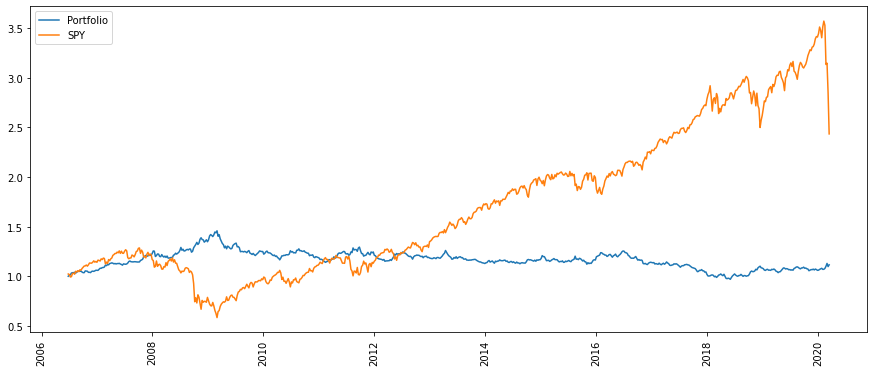

In [8]:
# calculate all-time results
simulation(df3)

Max draw-down: 0.0713175977785524
Total return: 0.10114894920447592
Annualized return: 0.07887127435191887


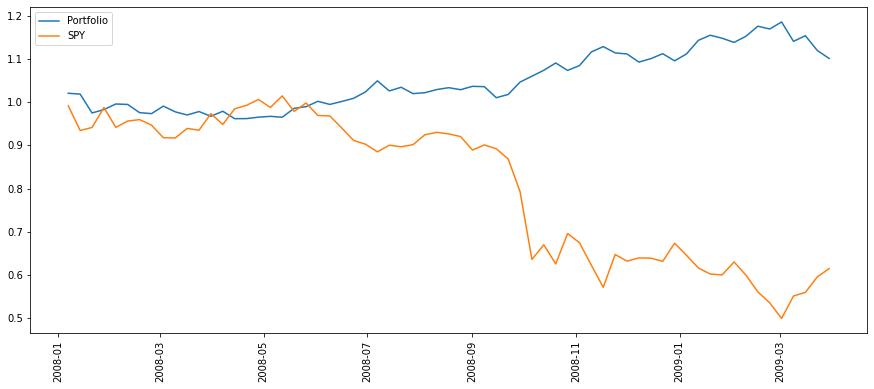

In [9]:
# calculate 2008 results
simulation(df3, min_dt='2008-01-01', max_dt='2009-03-31')

Max draw-down: 0.028286341757467803
Total return: 0.052390691430010294
Annualized return: 0.24767170100542057


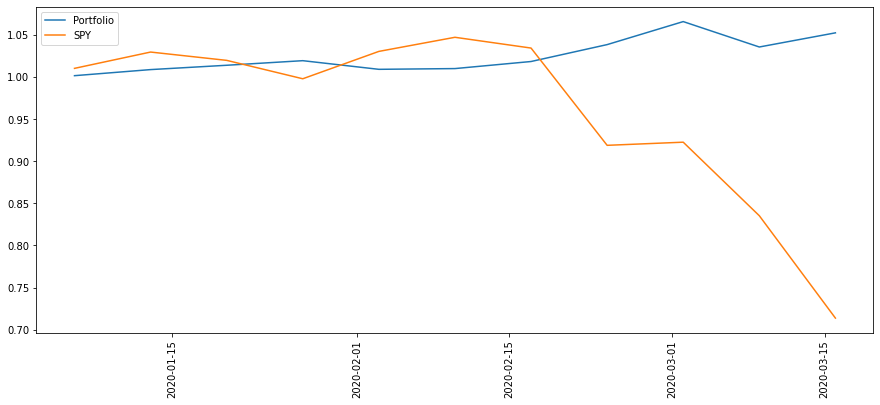

In [10]:
# calculate 2020 YTD
simulation(df3, min_dt='2020-01-01')